In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import os
sns.set_style('darkgrid')

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
alldata = pd.concat([train,test],sort=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualizing the Data 

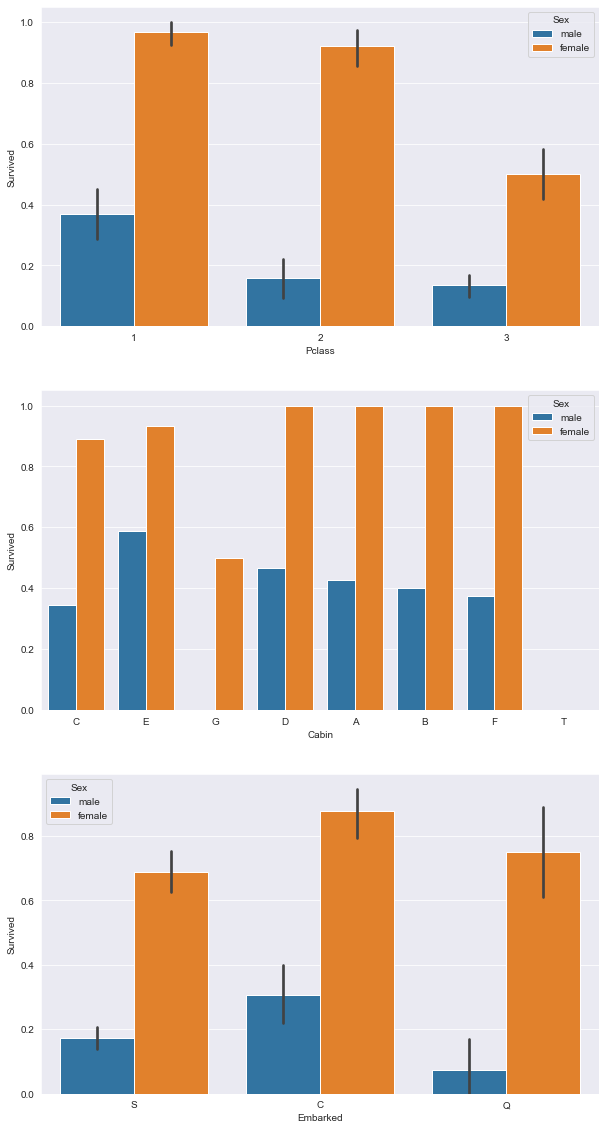

In [3]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
sns.barplot(y='Survived',
            x='Pclass',
            hue='Sex',
            data=train)

plt.subplot(3,1,2)
sns.barplot(y=alldata['Survived'],
            x=alldata['Cabin'].str[0],
            hue=alldata['Sex'],
            ci=None)

plt.subplot(3,1,3)
sns.barplot(y='Survived',
            x='Embarked',
            hue='Sex',
           data=train)

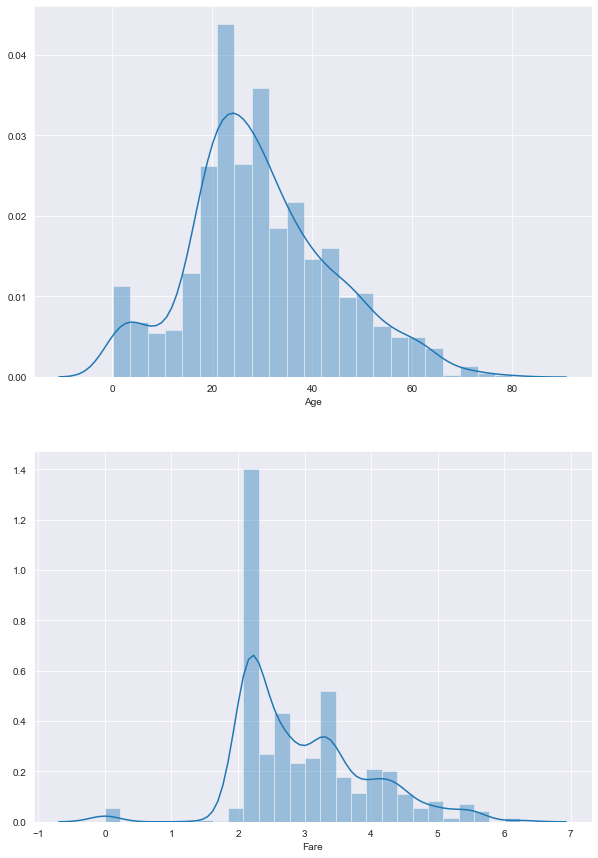

In [4]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
sns.distplot(alldata['Age'])


plt.subplot(2,1,2)
sns.distplot(np.log1p(alldata['Fare']))

## Feature Engineering & Pre Processing

In [5]:
alldata['Age'] = alldata['Age'].fillna(value=alldata['Age'].median())
alldata['Fare'] = alldata['Fare'].fillna(value=alldata['Fare'].median())
alldata['Embarked'] = alldata['Embarked'].fillna('S') #S is median

In [6]:
#Age
alldata.loc[ alldata['Age'] <= 20, 'Age_Band'] = 0
alldata.loc[(alldata['Age'] > 20) & (alldata['Age'] <= 25), 'Age_Band'] = 1
alldata.loc[(alldata['Age'] > 25) & (alldata['Age'] <= 30), 'Age_Band'] = 2
alldata.loc[(alldata['Age'] > 30) & (alldata['Age'] <= 40), 'Age_Band'] = 3
alldata.loc[ alldata['Age'] > 40, 'Age_Band'] = 4 

Now, as with age, classifying Fares into slabs, but first lognormalize it

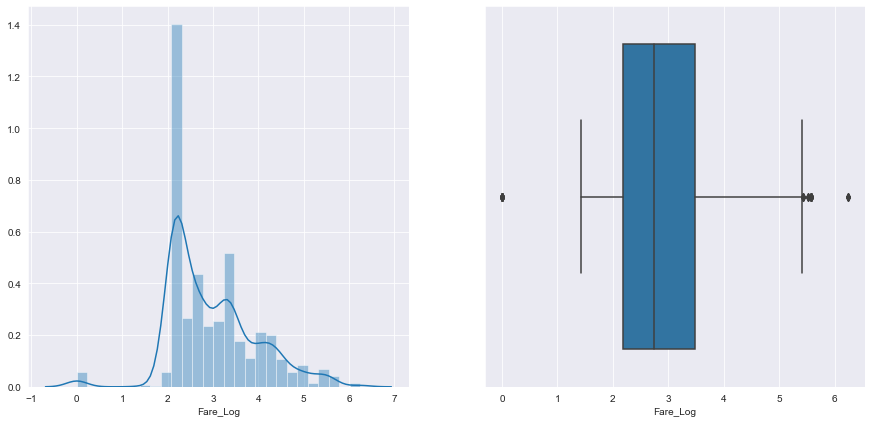

In [7]:
alldata['Fare_Log'] =np.log1p(alldata['Fare'])
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(alldata['Fare_Log'])


plt.subplot(1,2,2)
sns.boxplot(alldata['Fare_Log'])

In [8]:
alldata.loc[alldata['Fare_Log'] < 2,'Fare_Band'] = 1
alldata.loc[(alldata['Fare_Log'] >= 2) & (alldata['Fare_Log'] < 2.5),'Fare_Band'] = 2
alldata.loc[(alldata['Fare_Log'] >= 2.5) & (alldata['Fare_Log'] < 3),'Fare_Band'] = 3
alldata.loc[(alldata['Fare_Log'] >= 3) & (alldata['Fare_Log'] < 4),'Fare_Band'] = 4
alldata.loc[alldata['Fare_Log'] >= 4,'Fare_Band'] = 5

In [9]:
alldata[["Fare_Band","PassengerId","Survived"]].groupby('Fare_Band').count()

,PassengerId,Survived
Fare_Band,,
1.0,21,18
2.0,513,349
3.0,211,140
4.0,350,243
5.0,214,141


In [10]:
alldata[["Age_Band","PassengerId","Survived"]].groupby('Age_Band').count()

,PassengerId,Survived
Age_Band,,
0.0,248,179
1.0,195,122
2.0,429,285
3.0,210,155
4.0,227,150


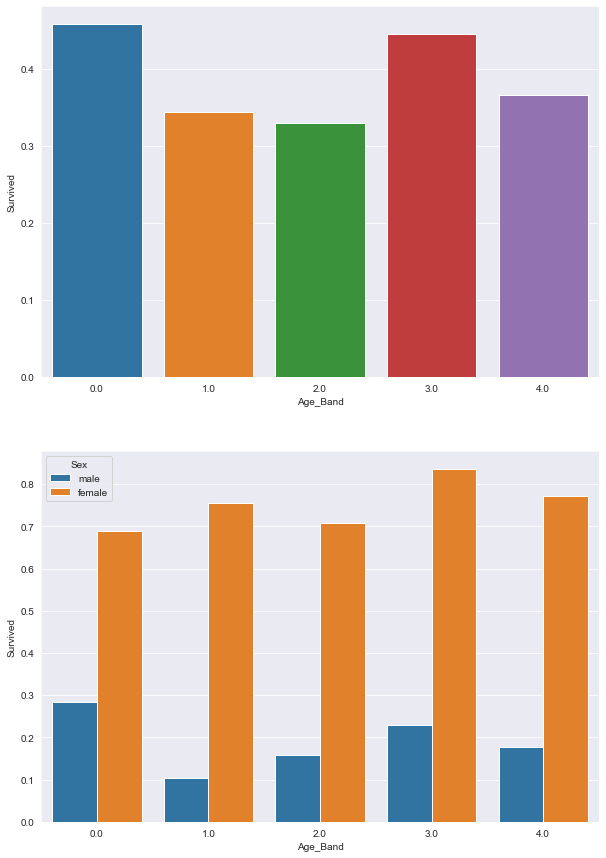

In [11]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
sns.barplot(y='Survived',
           x='Age_Band',
            ci=None,
           data=alldata)


plt.subplot(2,1,2)

sns.barplot(y='Survived',
           x='Age_Band',
            hue='Sex',
            ci=None,
           data=alldata)

In [12]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+\.)', name)
    
    if title_search:
        return title_search.group(1)
    return ""

alldata['Title'] = alldata['Name'].apply(get_title)
#alldata['Title'].value_counts()

In [13]:
alldata['Title'] = alldata['Title'].replace(['Capt.', 'Dr.', 'Major.', 'Rev.',"Col."], 'Officer.')
alldata['Title'] = alldata['Title'].replace(['Lady.', 'Countess.', 'Don.', 'Sir.', 'Jonkheer.', 'Dona.'], 'Royal.')
alldata['Title'] = alldata['Title'].replace(['Mlle.', 'Ms.'], 'Miss.')
alldata['Title'] = alldata['Title'].replace(['Mme.'], 'Mrs.')
alldata['Title'].value_counts()

Mr.         757
Miss.       264
Mrs.        198
Master.      61
Officer.     23
Royal.        6
Name: Title, dtype: int64

In [17]:
alldata['Family_Size'] = alldata['SibSp'] + alldata['Parch'] + 1
alldata['IsAlone'] = 0
alldata.loc[alldata['Family_Size']==1, 'IsAlone'] = 1
alldata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Band,Fare_Log,Fare_Band,Title,Family_Size,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0,2.110213,2.0,Mr.,2,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3.0,4.280593,5.0,Mrs.,2,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.0,2.188856,2.0,Miss.,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.0,3.990834,4.0,Mrs.,2,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3.0,2.202765,2.0,Mr.,1,1


In [18]:
#Cabin
alldata['Cabin'] = alldata['Cabin'].fillna('Missing')
alldata['Cabin'] = alldata['Cabin'].str[0]
#alldata['Cabin'].value_counts()

In [19]:
#Drop unwanted variables
all_1 = alldata.drop(['Name', 'Ticket'], axis = 1)
all_1.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_Band,Fare_Log,Fare_Band,Title,Family_Size,IsAlone
0,1,0.0,3,male,22.0,1,0,7.2500,M,S,1.0,2.110213,2.0,Mr.,2,0
1,2,1.0,1,female,38.0,1,0,71.2833,C,C,3.0,4.280593,5.0,Mrs.,2,0
2,3,1.0,3,female,26.0,0,0,7.9250,M,S,2.0,2.188856,2.0,Miss.,1,1
3,4,1.0,1,female,35.0,1,0,53.1000,C,S,3.0,3.990834,4.0,Mrs.,2,0
4,5,0.0,3,male,35.0,0,0,8.0500,M,S,3.0,2.202765,2.0,Mr.,1,1


### One Hot Encoding All Categories

In [20]:
#Uncomment Below Line to Go ahead with Onehot encoding

all_dummies = pd.get_dummies(all_1, drop_first = False)
all_dummies

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_Band,Fare_Log,Fare_Band,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Officer.,Title_Royal.
0,1,0.0,3,22.0,1,0,7.2500,1.0,2.110213,2.0,...,0,0,0,1,0,0,1,0,0,0
1,2,1.0,1,38.0,1,0,71.2833,3.0,4.280593,5.0,...,0,1,0,0,0,0,0,1,0,0
2,3,1.0,3,26.0,0,0,7.9250,2.0,2.188856,2.0,...,0,0,0,1,0,1,0,0,0,0
3,4,1.0,1,35.0,1,0,53.1000,3.0,3.990834,4.0,...,0,0,0,1,0,0,0,1,0,0
4,5,0.0,3,35.0,0,0,8.0500,3.0,2.202765,2.0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,28.0,0,0,8.0500,2.0,2.202765,2.0,...,0,0,0,1,0,0,1,0,0,0
414,1306,NaN,1,39.0,0,0,108.9000,3.0,4.699571,5.0,...,0,1,0,0,0,0,0,0,0,1
415,1307,NaN,3,38.5,0,0,7.2500,3.0,2.110213,2.0,...,0,0,0,1,0,0,1,0,0,0
416,1308,NaN,3,28.0,0,0,8.0500,2.0,2.202765,2.0,...,0,0,0,1,0,0,1,0,0,0


In [21]:
all_train = all_dummies[all_dummies['Survived'].notna()]
#all_train.head()
all_test = all_dummies[all_dummies['Survived'].isna()]
#all_test.head()

### Label Encoding Approach

In [22]:
#all_lab_enc = all_1.copy()
all_lab_enc[['Title','Survived']].groupby('Title').count()

NameError: name 'all_lab_enc' is not defined

In [23]:
all_lab_enc = all_lab_enc.drop(columns=['Cabin'])
all_lab_enc['Embarked'] = all_lab_enc['Embarked'].map({"C":0 , "S":1 , "Q":2})
all_lab_enc['Sex'] = all_lab_enc['Sex'].map( {'female': 1, 'male': 0} )

title_mapping = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Officer.": 5 ,"Royal.": 6}
all_lab_enc['Title'] = all_lab_enc['Title'].map( title_mapping )

all_lab_enc = all_lab_enc.drop(columns=['Family_Size','Parch','SibSp'])
all_lab_enc['Age_Band'] = all_lab_enc['Age_Band'].astype(int)
all_lab_enc['Fare_Band'] = all_lab_enc['Fare_Band'].astype(int)

all_lab_enc = all_lab_enc.drop(columns=['Age','Fare','Fare_Log'])

NameError: name 'all_lab_enc' is not defined

In [24]:
all_train = all_lab_enc[all_lab_enc['Survived'].notna()]
#all_train.head()
all_test = all_lab_enc[all_lab_enc['Survived'].isna()]
#all_test.head()

NameError: name 'all_lab_enc' is not defined

### Visualizing Correlation between Variables

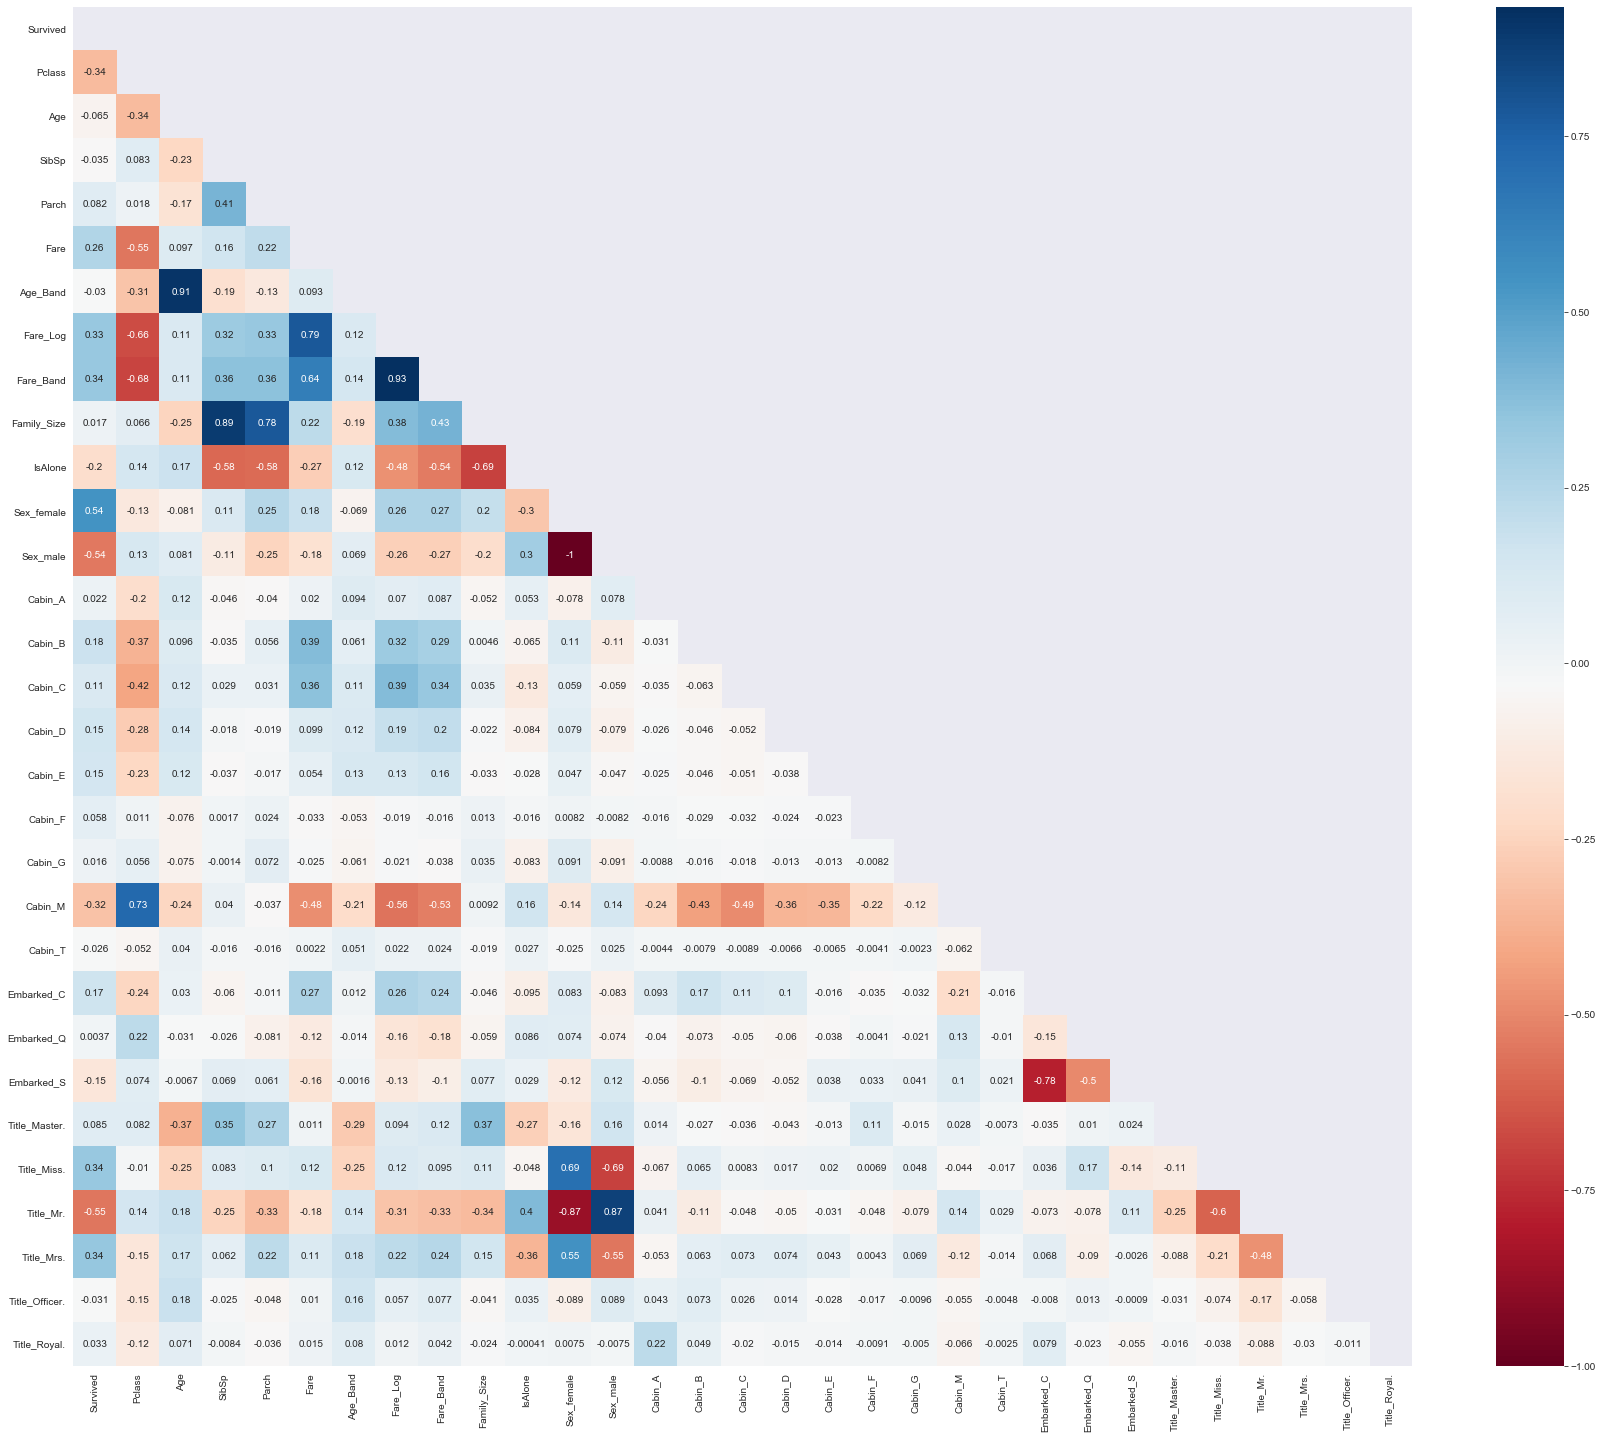

In [25]:
plt.figure(figsize=(30,15+10))
#plt.figure(figsize=(7,7))

corr_mat = all_train.drop(columns=['PassengerId']).corr()
mask = np.triu(np.ones_like(corr_mat, dtype=np.bool))
sns.heatmap(corr_mat,mask=mask,cmap='RdBu',annot=True)

## Model Creation and Evaluation

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


X = all_train.drop(['PassengerId','Survived'],axis=1)
y = all_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=0,
                                                    stratify = all_train['Survived'])

In [28]:
accuracy_model ={}

### Logistic Regression

In [29]:
logmodel = LogisticRegression(solver = 'liblinear')
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
acc_logreg = logmodel.score(X_test,y_test)

print(acc_logreg)
accuracy_model['Logistic Regression'] = acc_logreg

0.8470149253731343


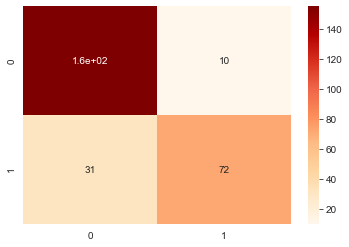

In [30]:
#print(classification_report(y_test,predictions))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,cmap='OrRd')

In [31]:
coeff_df = pd.DataFrame(X.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logmodel.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False).style.background_gradient(cmap="OrRd")

,Feature,Correlation
24,Title_Miss.,1.986956
10,Sex_male,1.135159
16,Cabin_F,0.901503
27,Title_Officer.,0.771177
15,Cabin_E,0.615884
7,Family_Size,0.493631
21,Embarked_Q,0.295493
17,Cabin_G,0.288362
13,Cabin_C,0.283084
22,Embarked_S,0.160314


### Decision Tree Classifier

In [32]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = (decision_tree.score(X_test, y_test))
print(acc_decision_tree)
accuracy_model['Decision Tree'] = acc_decision_tree
#print(classification_report(y_test,Y_pred))

0.7574626865671642


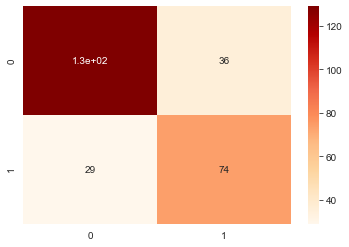

In [33]:
sns.heatmap(confusion_matrix(y_test,decision_tree.predict(X_test)),annot=True,
            cmap='OrRd');

### Random Forest Classifier

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [35]:
rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42,
                               n_jobs = -1)

In [36]:
#rf_random.fit(X_train,y_train)
#print(rf_random.best_params_)

0.832089552238806


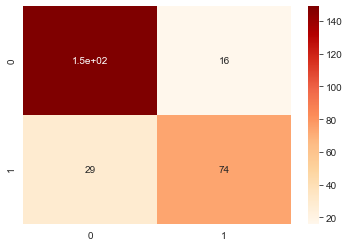

In [37]:
rf2 = RandomForestClassifier(n_estimators = 400,
                           min_samples_split = 5,
                           min_samples_leaf = 1,
                           max_features = 'sqrt',
                           max_depth = 30,
                           bootstrap = True)

rf2.fit(X_train,y_train)

acc_random_forest = rf2.score(X_test,y_test)
accuracy_model['Random Forest'] = acc_random_forest

print(acc_random_forest)
sns.heatmap(confusion_matrix(y_test,rf2.predict(X_test)),annot=True,cmap ='OrRd');

### Support Vector Machines

In [38]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)

acc_svc = svc.score(X_test, y_test)
print(acc_svc)
accuracy_model['Support Vector Machines'] = acc_svc

0.6567164179104478


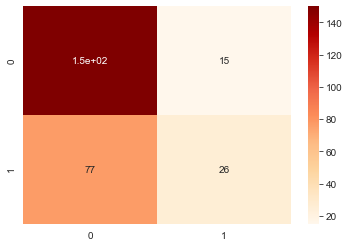

In [39]:
sns.heatmap(confusion_matrix(y_test,svc.predict(X_test)),
            annot=True,
            cmap='OrRd');

### KNN Classification

In [40]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = (knn.score(X_test, y_test))

accuracy_model['KNN'] = acc_knn
print(acc_knn)

0.7723880597014925


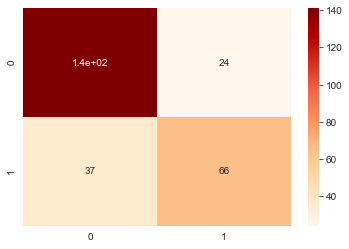

In [41]:
sns.heatmap(confusion_matrix(y_test,knn.predict(X_test)),
            annot=True,
            cmap='OrRd');

## Model Summary

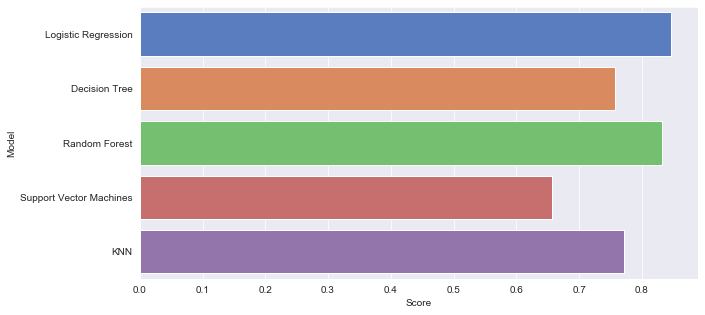

In [42]:
model_summ=pd.DataFrame({'Model': list(accuracy_model.keys()),
                          'Score': list(accuracy_model.values()) })

plt.figure(figsize=(10,5))
sns.barplot(data=model_summ,
           y='Model',
           x='Score',
           palette='muted')

## Prediction using Test Data

As the Logistic Regression Model performs the best, We will use it for Prediction

In [43]:
finalmodel = logmodel
test_features = all_test.drop(['PassengerId','Survived'],axis=1)

finalmodel.fit(X,y)
predictions = finalmodel.predict(test_features)

In [44]:
submissions = pd.DataFrame(zip(all_test.PassengerId,predictions.astype(int)),columns=['PassengerId','Survived'])
submissions.to_csv("Submissions.csv",index=False)